In [10]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import geopandas as gpd
import rioxarray as rxr
import yaml
from rasterio.plot import plotting_extent

# Seabee AI snippet



Detect on realfagsbygget

In [11]:
model = "detection/2022_nina_birds_20230817"
root_path = "./nrdata"
input_path = f"/home/notebook/shared-seabee-ns9879k"
mission_name = "Bergen_Realfagstaket_20230530"
orthophoto_file = f"seabirds/2023/{mission_name}/orthophoto/{mission_name}.tif"


Set these env variables if using minio for remote access
```env
MINIO_ACCESS_KEY=[KEY]
MINIO_SECRET_KEY=[KEY]
MINIO_BUCKET_MODELS=models
MINIO_URL=https://storage.seabee.sigma2.no
```

and install the seabee ai repo with the cell below if this is the first time


## Create configurations

`hub.yaml` configures the program and paths for the hub. We don't have a gpu on the hub and data is mounted so we can skip minio.

In [13]:
%%bash
mkdir -p config

cat <<EOF >./config/hub.yaml
DPATH_WORK: ./nrdata/work
DPATH_MODELS: ./nrdata/models
DPATH_RESULTS: ./nrdata/results
DPATH_PRETRAINED: ./nrdata/pretrained
MINIO:
    USE: true
TEST:
    DEVICE: cpu
EOF

`image_detection.yaml` configures the program for training or detection on various images. For the hub we use detection in production mode.

In [5]:
%%bash -s "$model" "$input_path" "$orthophoto_file"

cat <<EOF >./config/image_detection.yaml
mode: production
task: detection
score_threshold: 0.1  # For use in test mode only
model:
    id: $1
dataset:
    root: $2
    # NOTE: Filenames are extracted from the annotation.csv file if annotations are provided, else we use test_filenames
    # NOTE: Using tif's src.descriptions to extract red, green and blue channels
    annotations:
#       csv: None
        crs: "epsg:4326"
        column_main_class: species
        columns_subtasks: [activity,sex,age]
    test_filenames: 
      - $3
EOF

## Run the bird detection

1. preprocess the images

In [6]:
%%bash
nrseabee_det_preproc -c config/hub.yaml -o config/nrseabee_det_preproc.yaml config/image_detection.yaml

Created log file: nrdata/work/dataset/LOG_preprocess.txt
Started: 20231120-102859

 file: /home/notebook/shared-seabee-ns9879k/seabirds/2023/Bergen_Realfagstaket_20230530/orthophoto/Bergen_Realfagstaket_20230530.tif
 spatial sample rate: 7.810357668882609 mm x 7.810362387056105 mm
x_res: 0.0078103576688826086
y_res: 0.0078103623870561046
scale_factor_x: 1.5620715337765216
scale_factor_y: 1.562072477411221
height: 23795
width: 25121
 original data of shape (23795, 25121) re-sampled to (37169, 39240)
 Doing tile row 1/13
 saving nrdata/work/dataset/images/seabirds_2023_Bergen_Realfagstaket_20230530_orthophoto_Bergen_Realfagstaket_20230530_tif_1_1.jpg and the accompanying .jgw
Save complete
 saving nrdata/work/dataset/images/seabirds_2023_Bergen_Realfagstaket_20230530_orthophoto_Bergen_Realfagstaket_20230530_tif_1_2.jpg and the accompanying .jgw
Save complete
 saving nrdata/work/dataset/images/seabirds_2023_Bergen_Realfagstaket_20230530_orthophoto_Bergen_Realfagstaket_20230530_tif_1_3.jpg

2. start the detection run, (this can take some time)

In [19]:
%%bash
export $(grep -v '^#' .env | xargs)
nrseabee_det_test -c config/hub.yaml -o config/nrseabee_det_test.yaml config/nrseabee_det_preproc.yaml

Error while terminating subprocess (pid=616): 



Aborted!


Predictions to be saved in nrdata/results/detection/2022_nina_birds_20230817/2023-11-20-1104
 eta 0.0 minutes | image_id 001 / 182 | seabirds_2023_Bergen_Realfagstaket_20230530_orthophoto_Bergen_Realfagstaket_20230530_tif_1_1.jpg
 eta 76.0 minutes | image_id 002 / 182 | seabirds_2023_Bergen_Realfagstaket_20230530_orthophoto_Bergen_Realfagstaket_20230530_tif_1_2.jpg
 eta 101.7 minutes | image_id 003 / 182 | seabirds_2023_Bergen_Realfagstaket_20230530_orthophoto_Bergen_Realfagstaket_20230530_tif_1_3.jpg
 eta 113.9 minutes | image_id 004 / 182 | seabirds_2023_Bergen_Realfagstaket_20230530_orthophoto_Bergen_Realfagstaket_20230530_tif_1_4.jpg
 eta 119.5 minutes | image_id 005 / 182 | seabirds_2023_Bergen_Realfagstaket_20230530_orthophoto_Bergen_Realfagstaket_20230530_tif_1_5.jpg
 eta 122.8 minutes | image_id 006 / 182 | seabirds_2023_Bergen_Realfagstaket_20230530_orthophoto_Bergen_Realfagstaket_20230530_tif_1_6.jpg
 eta 126.2 minutes | image_id 007 / 182 | seabirds_2023_Bergen_Realfagstaket

3. generate the geopackage with detections

In [20]:
%%bash -s $mission_name

nrseabee_det_postproc -c config/hub.yaml -o config/$1_postproc.yaml config/nrseabee_det_test.yaml

wrote   nrdata/results/detection/2022_nina_birds_20230817/2023-11-20-1110/out.csv
 .. and nrdata/results/detection/2022_nina_birds_20230817/2023-11-20-1110/out.gpkg


In [21]:
with open(f"config/{mission_name}_postproc.yaml", "r") as f:
    post_conf = yaml.safe_load(f)
post_conf

{'dataset': {'annotations': {'column_main_class': 'species',
   'columns_subtasks': ['activity', 'sex', 'age'],
   'crs': 'epsg:4326'},
  'fn_patch_to_org_filename': ['seabirds_2023_Bergen_Realfagstaket_20230530_orthophoto_Bergen_Realfagstaket_20230530_tif_1_1.jpg::::seabirds/2023/Bergen_Realfagstaket_20230530/orthophoto/Bergen_Realfagstaket_20230530.tif',
   'seabirds_2023_Bergen_Realfagstaket_20230530_orthophoto_Bergen_Realfagstaket_20230530_tif_1_2.jpg::::seabirds/2023/Bergen_Realfagstaket_20230530/orthophoto/Bergen_Realfagstaket_20230530.tif',
   'seabirds_2023_Bergen_Realfagstaket_20230530_orthophoto_Bergen_Realfagstaket_20230530_tif_1_3.jpg::::seabirds/2023/Bergen_Realfagstaket_20230530/orthophoto/Bergen_Realfagstaket_20230530.tif',
   'seabirds_2023_Bergen_Realfagstaket_20230530_orthophoto_Bergen_Realfagstaket_20230530_tif_1_4.jpg::::seabirds/2023/Bergen_Realfagstaket_20230530/orthophoto/Bergen_Realfagstaket_20230530.tif',
   'seabirds_2023_Bergen_Realfagstaket_20230530_orthopho

In [22]:
df_birds =  gpd.read_file(f"{post_conf['dpath_results']}/out.gpkg").to_crs(32631)
df_birds.head()

,id,score_species,score_activity,score_sex,score_age,fileid,individualid,datetimereg,visibleonimage,comment,modelversion,manuallyverified,species,activity,sex,age,TEMP_image_filename,geometry
0,1,0.358105,0.985493,0.653622,0.998299,-1,1,2023-11-20 14:20:33,True,,1,False,2570,4,1,3,seabirds/2023/Bergen_Realfagstaket_20230530/or...,"POLYGON ((628288.641 6696627.929, 628288.641 6..."
1,2,0.293362,0.586050,0.586085,0.996080,-1,2,2023-11-20 14:20:33,True,,1,False,9225,3,1,3,seabirds/2023/Bergen_Realfagstaket_20230530/or...,"POLYGON ((628293.370 6696624.323, 628293.370 6..."
2,3,0.205094,0.766792,0.606715,0.991725,-1,3,2023-11-20 14:20:33,True,,1,False,590,3,1,3,seabirds/2023/Bergen_Realfagstaket_20230530/or...,"POLYGON ((628291.939 6696623.316, 628291.939 6..."
3,4,0.353211,0.596409,0.613742,0.988803,-1,4,2023-11-20 14:20:33,True,,1,False,2630,3,1,3,seabirds/2023/Bergen_Realfagstaket_20230530/or...,"POLYGON ((628266.478 6696615.354, 628266.478 6..."
4,5,0.982368,0.991186,0.754954,0.999492,-1,5,2023-11-20 14:20:33,True,,1,False,2570,1,1,3,seabirds/2023/Bergen_Realfagstaket_20230530/or...,"POLYGON ((628292.501 6696613.711, 628292.501 6..."


In [24]:
raster = rxr.open_rasterio(f"{input_path}/{orthophoto_file}").squeeze()
raster

<xarray.DataArray (band: 3, y: 23795, x: 25121)>
[1793262585 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1 2 3
  * x            (x) float64 6.282e+05 6.282e+05 ... 6.284e+05 6.284e+05
  * y            (y) float64 6.697e+06 6.697e+06 ... 6.696e+06 6.696e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     255
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      ('red', 'green', 'blue')

## Plot data

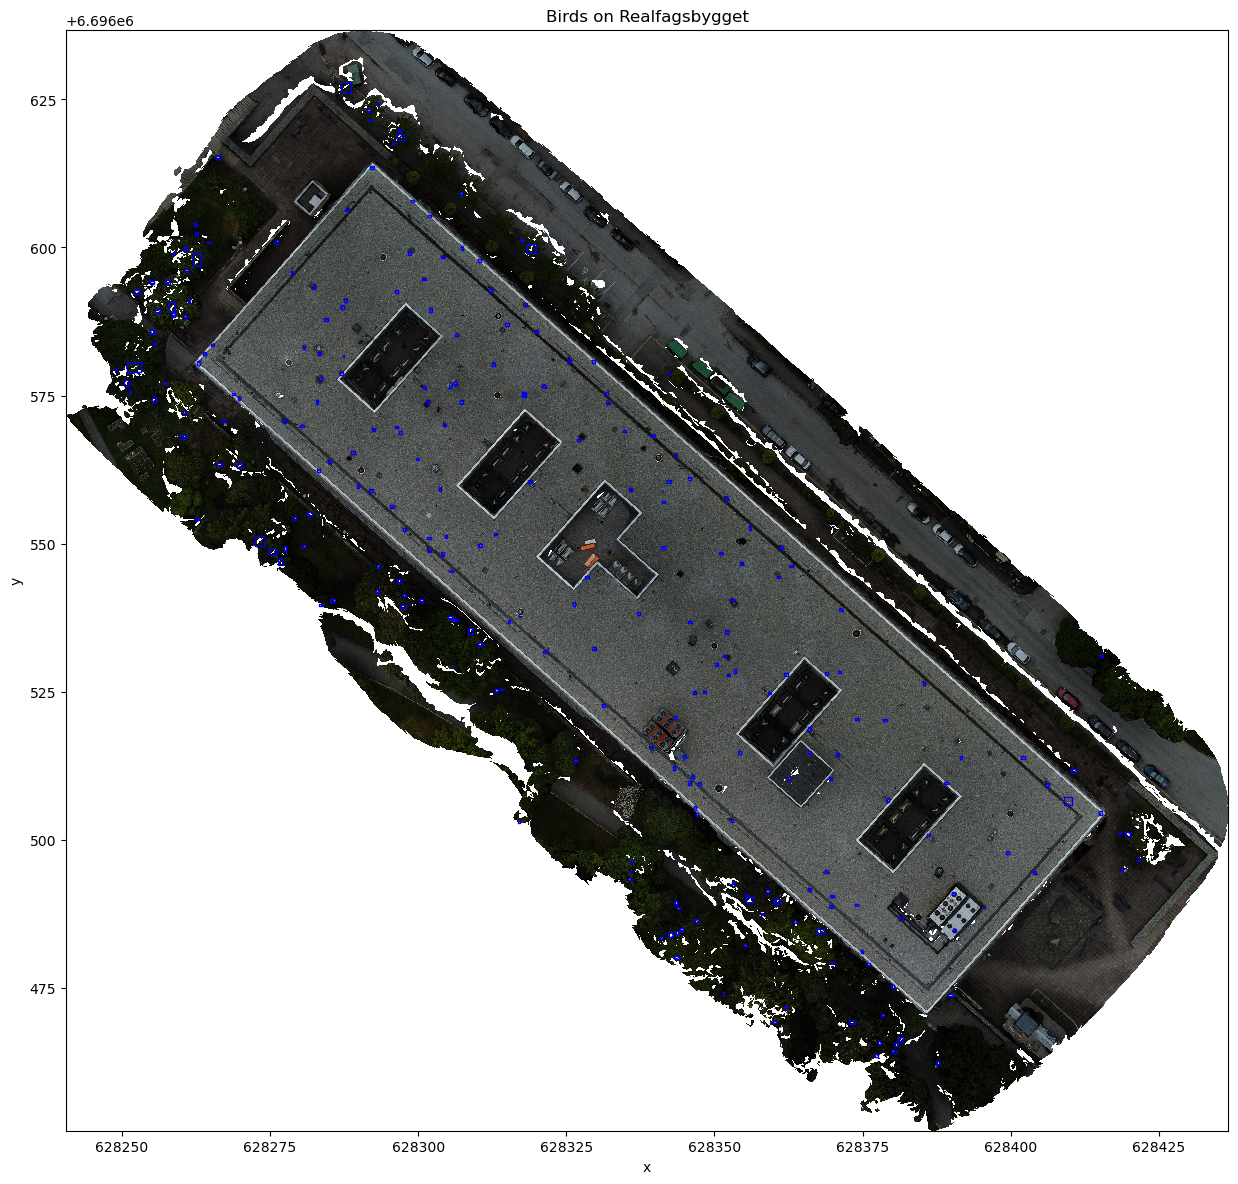

In [25]:
fig, ax = plt.subplots(figsize=(15, 15))
plot_extent = plotting_extent(raster[0], raster.rio.transform())
raster.plot.imshow(ax=ax, extend=plot_extent)
df_birds.plot(ax=ax, facecolor="none", edgecolor="blue", linewidth=1)
plt.title("Birds on Realfagsbygget")
plt.show()